In [1]:
using Plots
using FFTW
using DSP
using StatsPlots
using StatsBase
using Statistics
using Turing
using DataFrames

# Aim 2

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Preprocessing

### Data Importing

In [12]:
include("../helpers/importing.jl")
@enum EXPERIMENT E2 E3
lfp = Dict()
o2 = Dict()
lfp[E2] = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 101/")
o2[E2] = import_o2("Exp 2/R7/o2 r7.txt")
lfp[E3] = import_lfp("Exp 3/R4/2022-05-12_16-46-03/Record Node 101/")
o2[E3] = import_o2("Exp 3/R4/o2lfp r4.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [39824.0, 110812.0, 184330.0, 247107.0, 320937.0, 384378.0, 4…
  "sync"       => [13906.0, 24375.0, 34848.0, 45328.0, 55812.0, 66277.0, 76756.…
  "data"       => [-35.75, -39.797, -34.719, -32.188, -36.406, -35.406, -40.813…
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  961349.…

### Extracting Envelope of LFP Data

In [46]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp[E3]["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 45]
lfp_envelopes = []
for i in 1:length(lfp[E3]["data"][:,1])
    F = fft(lfp[E3]["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, banded_lfp)
end
lfp_envelopes = lfp_envelopes[2]

963584-element Vector{Float32}:
 -34.78211
 -36.918537
 -38.90503
 -40.668438
 -42.147152
 -43.295185
 -44.084866
 -44.508083
 -44.57577
 -44.315647
   ⋮
 -20.337725
 -20.977314
 -21.89585
 -23.100903
 -24.584484
 -26.322056
 -28.272596
 -30.379963
 -32.575535

### Band-Pass Filtering O2 Data

In [16]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2[E3]["data"])
freqs = fftfreq(length(o2[E3]["data"]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2 = real(ifft(band_pass_F))

961359-element Vector{Float32}:
 -0.13050681
 -1.8061608
 -3.417992
 -4.9140024
 -6.2479978
 -7.3823695
 -8.29025
 -8.9569235
 -9.380398
 -9.5711355
  ⋮
 10.337578
  9.901386
  9.268901
  8.430494
  7.3866596
  6.1489973
  4.740436
  3.1946077
  1.5543628

### Visualising Data

This section will plot the effect after a single laser event has occurred

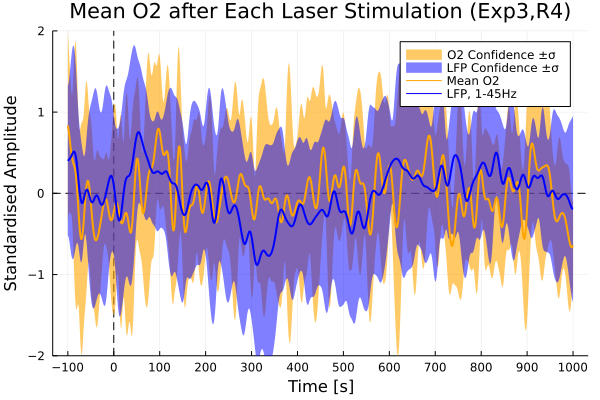

In [49]:
o2_starts = findall(x->x in o2[E3]["laser"], o2[E3]["timestamps"])
start = -100
stop = 1000

vline([0], linestyle=:dash, colour=:grey, label=false, c="Black", ylim=(-2,2))
hline!([0], linestyle=:dash, colour=:grey, label=false, c="Black")

# Get variances for each datapoint
var_o2 = []
var_lfp = []
for i in 1:stop-start+1
    o2_all = []
    lfp_all = []
    for j in 1:length(o2_starts)
        data = standardize(ZScoreTransform, banded_o2[o2_starts[j]+start:o2_starts[j]+stop])
        push!(o2_all, data[i])
        data = standardize(ZScoreTransform, lfp_envelopes[lfp_starts[j]+start:lfp_starts[j]+stop])
        push!(lfp_all, data[i])
    end
    push!(var_o2, sqrt(var(o2_all)))
    push!(var_lfp, sqrt(var(lfp_all)))
end

# Plot the mean of the datapoints
mean_o2 = zeros(length(banded_o2[o2_starts[1]+start:o2_starts[1]+stop]))
mean_lfp = zeros(length(lfp_envelopes[o2_starts[1]+start:o2_starts[1]+stop]))
for i in 1:length(o2_starts)
    data = standardize(ZScoreTransform, banded_o2[o2_starts[i]+start:o2_starts[i]+stop])
    mean_o2 += data
    data = standardize(ZScoreTransform, lfp_envelopes[lfp_starts[i]+start:lfp_starts[i]+stop])
    mean_lfp += data
end
mean_o2 ./= length(o2_starts)
mean_lfp ./= length(o2_starts)
plot!((start:stop), mean_o2.-vars, fillrange=mean_o2.+vars, fillalpha = 0.6, linealpha=0, c="Orange", label="O2 Confidence ±σ")
plot!((start:stop), mean_lfp.-var_lfp, fillrange=mean_lfp.+var_lfp, fillalpha = 0.5, linealpha=0, c="Blue", label="LFP Confidence ±σ")

plot!((start:stop), mean_o2, c="Orange", linewidth=2, label="Mean O2")
plot!((start:stop), mean_lfp, label="LFP, 1-45Hz", c="Blue", linewidth=2)  

xticks!((start:100:stop))
title!("Mean O2 after Each Laser Stimulation (Exp3,R4)")
xlabel!("Time [ms]")
ylabel!("Standardised Amplitude")

In [48]:
cor(mean_o2, mean_lfp)

0.18552458564044877

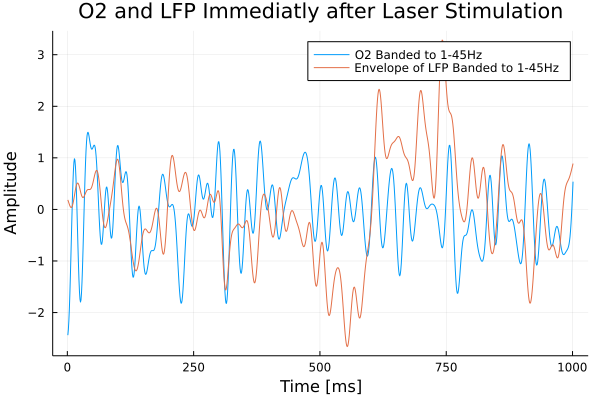

In [23]:
laser_flag = 4

o2_start = findall(x->x==o2[E3]["laser"][laser_flag], o2[E3]["timestamps"])[1]
lfp_start = findall(x->x==lfp[E3]["laser"]["on"][laser_flag], lfp[E3]["timestamps"])[1]
increment = 1000

lfp_channels_mean = zeros(increment+1)
for i in 1:length(lfp[E3]["data"][:,1])
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= length(lfp[E3]["data"][:,1])

plot(banded_o2[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(standardize(ZScoreTransform, lfp_envelopes[4][lfp_start:lfp_start+increment]), label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [8]:
for i in 1:length(lfp["data"][:,1])
    core = cor(banded_o2[o2_start:o2_start+increment], lfp_envelopes[i][lfp_start:lfp_start+increment])
    println("Channel $(i) correlation is: $(core)")
end
println(cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))

Channel 1 correlation is: 0.17519711
Channel 2 correlation is: 0.012038972
Channel 3 correlation is: -0.10685514
Channel 4 correlation is: -0.07744588
0.018714726386265385


This first laser event shows a very promising correlation between the two datasets. Now lets plot the correlation value for each laser event.

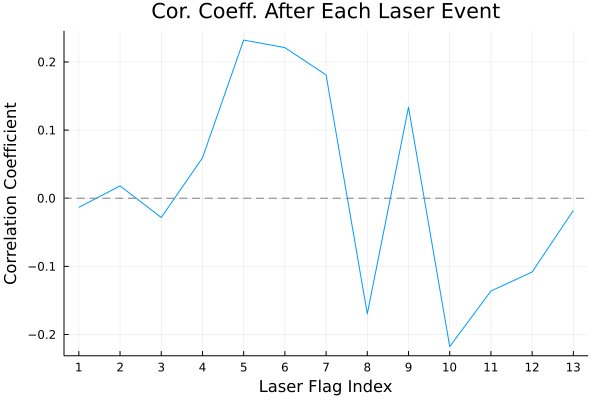

In [26]:
increment = 1000
cors = []

for flag in 1:length(o2[E3]["laser"])
    o2_start = findall(x->x==o2[E3]["laser"][flag], o2[E3]["timestamps"])[1]
    lfp_start = findall(x->x==lfp[E3]["laser"]["on"][flag], lfp[E3]["timestamps"])[1]

    lfp_channels_mean = zeros(increment+1)

    for i in 1:length(lfp[E3]["data"][:,1])
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
    end
    lfp_channels_mean ./= length(lfp[E3]["data"][:,1])

    push!(cors, cor(banded_o2[o2_start:o2_start+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Laser Event")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:length(o2[E3]["laser"])))
ylabel!("Correlation Coefficient")


### All Events Averaged

This section will average the data immediately after each event and plot the result.

In [27]:
o2_starts = findall(x->x in o2[E3]["laser"], o2[E3]["timestamps"])[1:13]
lfp_starts = findall(x->x in lfp[E3]["laser"]["on"], lfp[E3]["timestamps"])[1:13]
increment = 1000

o2_subset_mean = zeros(increment+1)
lfp_subset_mean = zeros(increment+1)

for i in o2_starts
    o2_subset_mean += standardize(ZScoreTransform, banded_o2[i:i+increment])
end

for i in 1:4
    for j in lfp_starts
        lfp_subset_mean += standardize(ZScoreTransform, lfp_envelopes[i][j:j+increment])
    end
end

o2_subset_mean ./= length(o2_starts)
lfp_subset_mean ./= length(lfp_starts)
lfp_subset_mean ./= 4

1001-element Vector{Float64}:
  0.11024754913523793
  0.06286189798265696
  0.009596187657175155
 -0.04770126008392813
 -0.10694439234570242
 -0.16590701795827884
 -0.22232285179555988
 -0.27398905063119644
 -0.31886663323698133
 -0.3551761261187494
  ⋮
 -0.18570092521034753
 -0.19978502227996403
 -0.21218717087490055
 -0.2222284758463502
 -0.22925305955756742
 -0.23267672698085123
 -0.23203370763132206
 -0.227024534645562
 -0.21755401045084

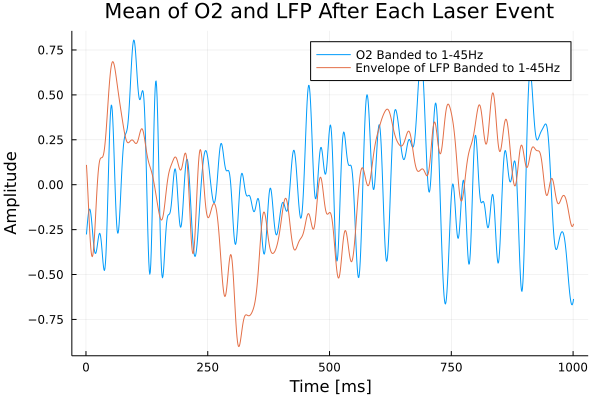

In [28]:
plot(o2_subset_mean, label="O2 Banded to 1-45Hz")
plot!(lfp_subset_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [10]:
cor(o2_subset_mean, lfp_subset_mean)

0.017007361741057717

There is still some correlation after the laser events have been averaged. However, it is far weaker than the first data point.

In [ ]:
laser_flag = 1

o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_starts = findall(x->x in lfp["laser"]["on"], lfp["timestamps"])[1:13]
increments = lfp_starts .- lfp_starts[1]
increment = 1000
cors = []

for flag in 1:13
    lfp_channels_mean = zeros(increment+1)

    for i in 1:4
        lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_starts[flag]:lfp_starts[flag]+increment])
    end
    lfp_channels_mean ./= 4

    push!(cors, cor(banded_o2[o2_start+increments[flag]:o2_start+increments[flag]+increment], lfp_channels_mean))
end

plot(cors, legend=false)
title!("Cor. Coeff. After Each Laser Event")
xlabel!("Laser Flag Index")
hline!([0], linestyle=:dash, colour=:grey)
xticks!((1:length(o2["laser"])))
ylabel!("Correlation Coefficient")

## Modelling the First Laser Flag

As there is a clear correlation between the O2 and LFP data at the first laser flag, it will be possible to make a model. The aim of this section if to create an AR model for the purpose of practising modelling and finding a basic relationship.

$$y_i \sim Normal(\mu_i, \sigma_i)$$

$$\mu_i = \sum_{j=1}^{10}\beta_jx_{i-j}$$

$$\beta_j \sim Normal(0, \tau_\beta)$$

$$\tau_\beta \sim Gamma(2, 2)$$

$$\sigma_i \sim Gamma(2, 2)$$

In [ ]:
laser_flag = 1
o2_start = findall(x->x==o2["laser"][laser_flag], o2["timestamps"])[1]
lfp_start = findall(x->x==lfp["laser"]["on"][laser_flag], lfp["timestamps"])[1]
increment = 1000

lfp_channels_mean = zeros(increment+1)
for i in 1:4
    lfp_channels_mean += standardize(ZScoreTransform, lfp_envelopes[i][lfp_start:lfp_start+increment])
end
lfp_channels_mean ./= 4

o2_subset = banded_o2[o2_start:o2_start+increment]
lfp_subset = lfp_channels_mean

In [ ]:
@model function AR(y, x)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ filldist(Normal(0, 1), 10)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i] .* beta .* tau_beta)
        y[i] ~ Normal(mu, sigma)
    end
end

In [ ]:
# Define a moving average
lfp_moving_avg = []
for i in 10:length(lfp_subset)
    push!(lfp_moving_avg, mean(lfp_subset[i-9:i]))
end

In [ ]:
@model function ARMA(y, x, xhat)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ filldist(Normal(0, 1), 10)
    tau_alpha ~ Gamma(2, 2)
    alpha ~ Normal(0, 1)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i] .* beta .* tau_beta) + xhat[i-9] * alpha * tau_alpha
        y[i] ~ Normal(mu, sigma)
    end
end

In [ ]:
model = ARMA(o2_subset, lfp_subset, lfp_moving_avg)
chain = sample(model, NUTS(0.65), 1000)

In [ ]:
plot(chain)

In [ ]:
length(chain)
parms = chain.name_map.parameters

using Random, Distributions
Random.seed!(123) # Setting the seed

function posteriorSample(chain)
    parms = chain.name_map.parameters
    idx = rand(1:length(chain))
    return map(x->chain[x].value[idx] , parms)
end

postSample = [posteriorSample(chain) for i in 1:1000]

predictions = []
for i in 10:length(lfp_subset)
    pred_i = []
    for sample in postSample
        mu = sum(lfp_subset[i-9:i] .* sample[1:10] .* sample[12])
        post = rand(Normal(mu, sample[11]), 1)
        push!(pred_i, post[1])
    end
    push!(predictions, pred_i)
end

In [ ]:
means = [mean(predictions[i]) for i in 1:length(predictions)]
vars = [var(predictions[i]) for i in 1:length(predictions)]

plot(means, label="μ")
plot!(o2_subset[10:end], label="O2")
plot!(means.-vars, fillrange=means.+vars, fillalpha = 0.35, linealpha=0, c="Blue", label="σ")
plot!(means.-(2*vars), fillrange=means.+(2*vars), fillalpha = 0.35, linealpha=0, c="Light Blue", label="2σ")

title!("Posterior Prediction of O2 Data")
xlabel!("Time [ms]")
ylabel!("Amplitude")

In [ ]:
cor(means, o2_subset[10:end])

The model above does a fairly good job of predicting O2 considering that there was not a large correlation to LFP. However, there does seem to be some sort of undesirable smoothing effect. Also the posteriors look quite large which signals that there needs to be more data or stronger priors. It is visible in the chain that there is a region between samples 270-360 where is autocorrelation happening, the sampler should be run longer and/or with more chains to mitigate this effect. 

### Addressing Multicollinearity

The issue with the model above is that there will be an auto correlation between $x_{i-10}$ to $x_i$ this will cause multicollinearity between all values of $\beta$ making their actual values arbitrary. This can be fixed by modifying the model.

$$y_i \sim Normal(\mu_i, \sigma_i)$$

$$\mu_i = \beta\sum_{j=1}^{10}x_{i-j}$$

$$\beta \sim Normal(0, \tau_\beta)$$

$$\tau_\beta \sim Gamma(2, 2)$$

$$\sigma_i \sim Gamma(2, 2)$$

In [ ]:
@model function AR_no_multi_colin(y, x)
    # Priors
    tau_beta ~ Gamma(2, 2)
    beta ~ Normal(0, 1)
    sigma ~ Gamma(2, 2)

    for i in 10:length(y)
        mu = sum(x[i-9:i]) * beta * tau_beta
        y[i] ~ Normal(mu, sigma)
    end
end

In [ ]:
model = AR_no_multi_colin(o2_subset, lfp_subset)
chain = sample(model, NUTS(0.65), 1000)

In [ ]:
plot(chain)

In [ ]:
length(chain)
parms = chain.name_map.parameters

using Random, Distributions
Random.seed!(123) # Setting the seed

function posteriorSample(chain)
    parms = chain.name_map.parameters
    idx = rand(1:length(chain))
    return map(x->chain[x].value[idx] , parms)
end

postSample = [posteriorSample(chain) for i in 1:1000]

predictions = []
for i in 10:length(lfp_subset)
    pred_i = []
    for sample in postSample
        mu = sum(lfp_subset[i-9:i]) * sample[1] * sample[3]
        post = rand(Normal(mu, sample[2]), 1)
        push!(pred_i, post[1])
    end
    push!(predictions, pred_i)
end

In [ ]:
means = [mean(predictions[i]) for i in 1:length(predictions)]
vars = [var(predictions[i]) for i in 1:length(predictions)]

plot(means, label="μ")
plot!(o2_subset[10:end], label="O2")
plot!(means.-vars, fillrange=means.+vars, fillalpha=0.35, linealpha=0, c="Blue", label="σ")
plot!(means.-(2*vars), fillrange=means.+(2*vars), fillalpha=0.35, linealpha=0, c="Light Blue", label="2σ")

title!("Posterior Prediction of O2 Data")
xlabel!("Time [ms]")
ylabel!("Amplitude")